In [1]:
import h5py
from wrapper4 import SolverTSX
from denormalize import plot_observations_vs_reference, create_denormalizer_tsx_9subdomains


In [2]:
import os

prior = create_denormalizer_tsx_9subdomains()

no_subdomains = 9
no_parameters = no_subdomains * 4 + 3  # 36
no_observations = 2 * 18 * 4  # 144

# create solver instances
rtol = 1e-10
solver_iterative = SolverTSX(solver_type='iterative', rtol=rtol)

master_folder = "exported_data"

with h5py.File('subset_inputs_outputs.h5', 'r') as file:
    inputs = file['inputs'][:]
    outputs = file['outputs'][:]

for i in range(20):
    subfolder = f'{master_folder}/testrun_{i}'
    os.makedirs(subfolder, exist_ok=True)
    parameter_estimates = inputs[i, :]
    solver_iterative.set_parameters(prior.transform(parameter_estimates))
    solver_iterative.filename = f"{subfolder}/data"
    solver_iterative.get_observations()


Matrix saved as blocks to exported_data/testrun_0/data_elastic.h5
Matrix saved to exported_data/testrun_0/data_full.h5
Matrix saved as blocks to exported_data/testrun_0/data_as_blocks.h5
Matrix saved as blocks to exported_data/testrun_0/data_diag_preco.h5
Matrix saved as blocks to exported_data/testrun_0/data_triang_preco.h5
Solver on average used 14.995804195804196 iterations
Matrix saved as blocks to exported_data/testrun_1/data_elastic.h5
Matrix saved to exported_data/testrun_1/data_full.h5
Matrix saved as blocks to exported_data/testrun_1/data_as_blocks.h5
Matrix saved as blocks to exported_data/testrun_1/data_diag_preco.h5
Matrix saved as blocks to exported_data/testrun_1/data_triang_preco.h5
Solver on average used 15.008391608391609 iterations
Matrix saved as blocks to exported_data/testrun_2/data_elastic.h5
Matrix saved to exported_data/testrun_2/data_full.h5
Matrix saved as blocks to exported_data/testrun_2/data_as_blocks.h5
Matrix saved as blocks to exported_data/testrun_2/dat

In [5]:
from tunnel_with_subdomains import load_matrices_from_hdf5, load_vectors_from_hdf5

problem_no = 0
path_to_data = f"exported_data/testrun_{problem_no}/"

# loading
A_big = load_matrices_from_hdf5(f"{path_to_data}data_full.h5")[0]
A_blocks = load_matrices_from_hdf5(f"{path_to_data}data_as_blocks.h5")
A_elastic = load_matrices_from_hdf5(f"{path_to_data}data_elastic.h5")  # elastic matrix on big space
blocks = load_matrices_from_hdf5(f"{path_to_data}data_as_blocks.h5")  # 4 csr matrices in list
Pdblocks = load_matrices_from_hdf5(f"{path_to_data}data_diag_preco.h5")  # 4 csr matrices for preco, two are zero
Ptblocks = load_matrices_from_hdf5(f"{path_to_data}data_triang_preco.h5")
rhs_u, rhs_p = load_vectors_from_hdf5(f"{path_to_data}data_rhs.h5")  # each rhs_* is a list of ndarrays
sol_u, sol_p = load_vectors_from_hdf5(f"{path_to_data}data_sol.h5")  # each rhs_* is a list of ndarrays

In [9]:
import numpy as np


import scipy.sparse as sp

# Compute the difference between A_big and its transpose
diff = A_big - A_big.T

# Compute the Frobenius norm of the difference
norm_diff = sp.linalg.norm(diff)

# Compute the relative difference
relative_diff = norm_diff / sp.linalg.norm(A_big)

print(f"Norm of A_big - A_big.T: {norm_diff:.4e}")
print(f"Relative difference: {relative_diff:.4e}")
print(f"Is A_big symmetric (within numerical tolerance)? {norm_diff < 1e-10}")

# Check number of non-zero elements in the difference
nnz_diff = diff.nnz
print(f"Number of non-zero elements in the difference: {nnz_diff}")

# If the matrix is small enough, we can find the maximum absolute difference
if diff.nnz > 0 and diff.nnz < 1000:
    abs_diff = abs(diff.data)
    max_diff = abs_diff.max()
    print(f"Maximum absolute difference: {max_diff:.4e}")

Norm of A_big - A_big.T: 3.5479e-03
Relative difference: 1.0092e-16
Is A_big symmetric (within numerical tolerance)? False
Number of non-zero elements in the difference: 218244


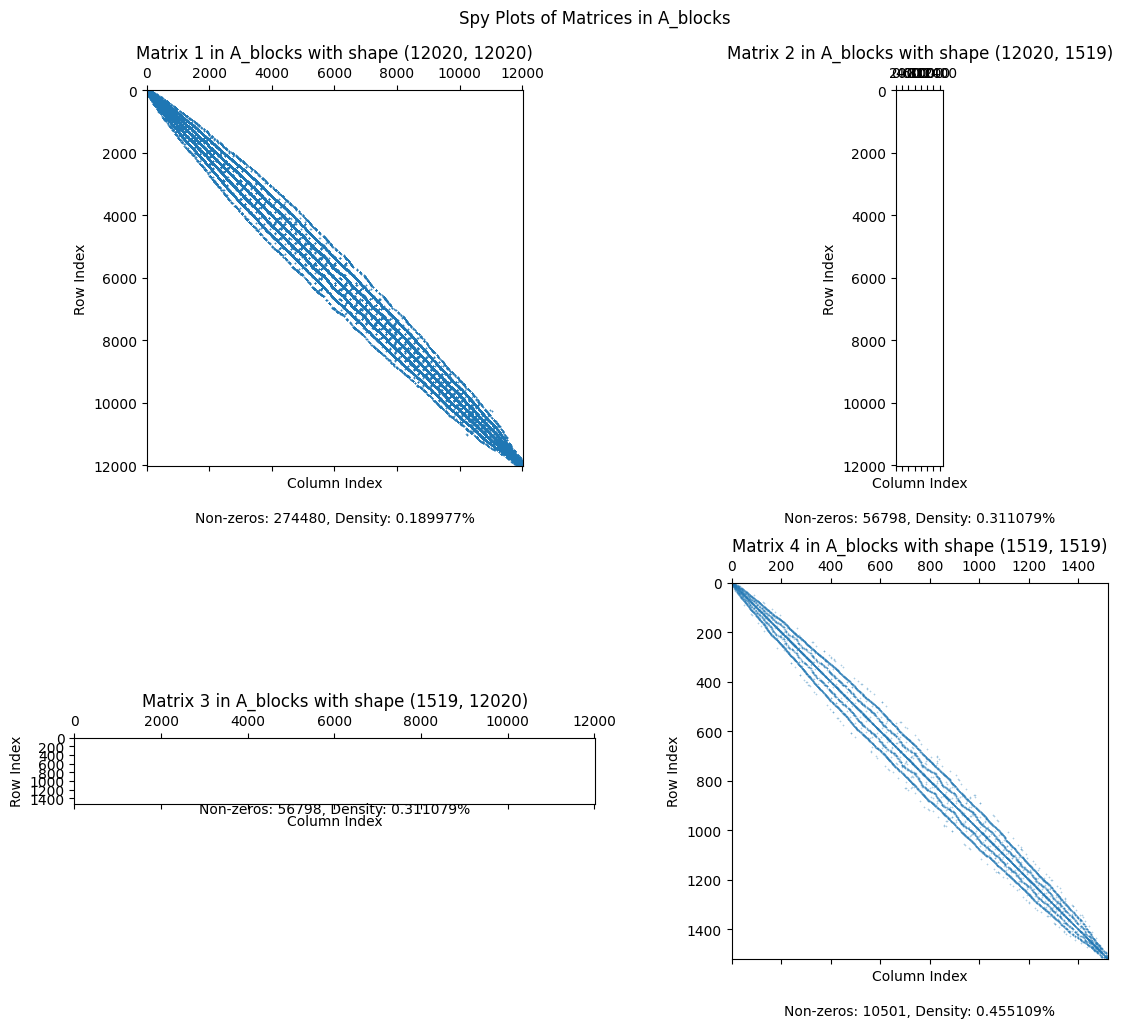

In [50]:
# Create spy plots to visualize the structure of matrices in A_blocks
import matplotlib.pyplot as plt

# Set up a figure with 2x2 subplots for the 4 matrices in A_blocks
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot each matrix in A_blocks
for i, matrix in enumerate(Pdblocks):
    ax = axes[i]
    ax.spy(matrix, markersize=0.1)
    ax.set_title(f'Matrix {i+1} in A_blocks with shape {matrix.shape}')
    ax.set_xlabel('Column Index')
    ax.set_ylabel('Row Index')
    
    # Display basic information about the matrix
    density = matrix.nnz / (matrix.shape[0] * matrix.shape[1]) * 100
    ax.text(0.5, -0.15, f"Non-zeros: {matrix.nnz}, Density: {density:.6f}%", 
            transform=ax.transAxes, ha='center')

plt.tight_layout()
plt.suptitle("Spy Plots of Matrices in A_blocks", y=1.02)
plt.show()

In [29]:
print(A_blocks[0].shape)
print(A_blocks[1].shape)
print(A_blocks[2].shape)
print(A_blocks[3].shape)


(12020, 12020)
(12020, 1519)
(1519, 12020)
(1519, 1519)


Is A_elastic[0] symmetric? False
Is A_elastic[0] positive semidefinite? False
Dimension of kernel: 0
Smallest eigenvalues: [-2.15219642e-03  6.31228990e-05  2.38917972e-03  5.28568189e+07
  5.76931006e+07]
Largest eigenvalues: [1.79485306e+12 1.85103259e+12 1.85863505e+12 1.88136798e+12
 1.93638901e+12]
Condition number (excluding kernel): 3.07e+16


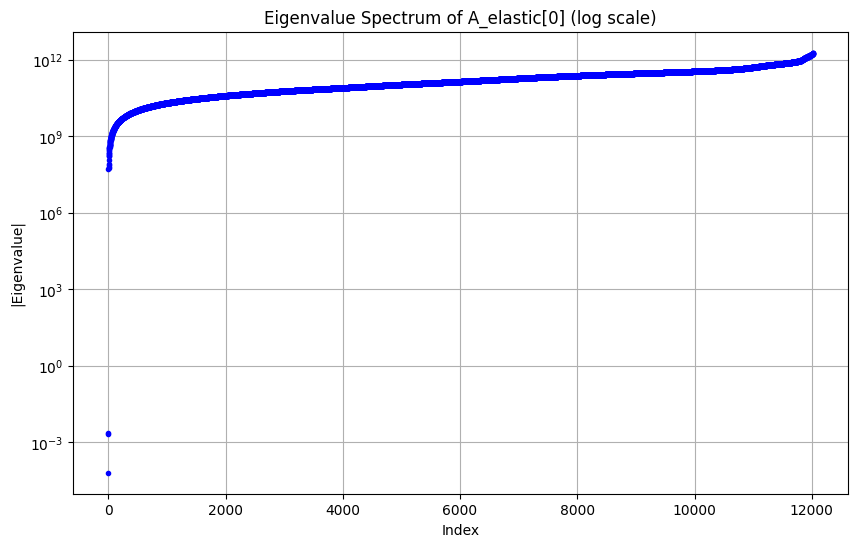

In [42]:
import numpy as np

import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

# Convert sparse matrix to dense for analysis
A_dense = A_elastic[0].toarray()

# Check if matrix is symmetric
is_symmetric = np.allclose(A_dense, A_dense.T, rtol=1e-10, atol=1e-10)
print(f"Is A_elastic[0] symmetric? {is_symmetric}")

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(A_dense) if is_symmetric else np.linalg.eig(A_dense)

# Sort eigenvalues and corresponding eigenvectors
idx = eigenvalues.argsort()
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Check positive semidefiniteness
is_psd = np.all(eigenvalues >= -1e-10)
print(f"Is A_elastic[0] positive semidefinite? {is_psd}")

# Find kernel vectors (null space)
tol = 1e-10
kernel_indices = np.where(np.abs(eigenvalues) < tol)[0]
kernel_vectors = eigenvectors[:, kernel_indices]
kernel_dim = len(kernel_indices)

print(f"Dimension of kernel: {kernel_dim}")
print(f"Smallest eigenvalues: {eigenvalues[:5]}")
print(f"Largest eigenvalues: {eigenvalues[-5:]}")

# Plot eigenvalue spectrum
plt.figure(figsize=(10, 6))
plt.semilogy(np.abs(eigenvalues), 'bo', markersize=3)
plt.grid(True)
plt.title(f"Eigenvalue Spectrum of A_elastic[0] (log scale)")
plt.xlabel("Index")
plt.ylabel("|Eigenvalue|")

# If there are kernel vectors, plot a few of them
if kernel_dim > 0:
    plt.figure(figsize=(12, 8))
    num_to_plot = min(4, kernel_dim)
    
    for i in range(num_to_plot):
        plt.subplot(2, 2, i+1)
        plt.plot(kernel_vectors[:, i], 'r-')
        plt.title(f"Kernel vector {i+1}")
        plt.grid(True)
    
    plt.tight_layout()

# Check condition number excluding zero eigenvalues
nonzero_eigenvalues = eigenvalues[np.abs(eigenvalues) > tol]
if len(nonzero_eigenvalues) > 0:
    condition_number = np.max(np.abs(nonzero_eigenvalues)) / np.min(np.abs(nonzero_eigenvalues))
    print(f"Condition number (excluding kernel): {condition_number:.2e}")

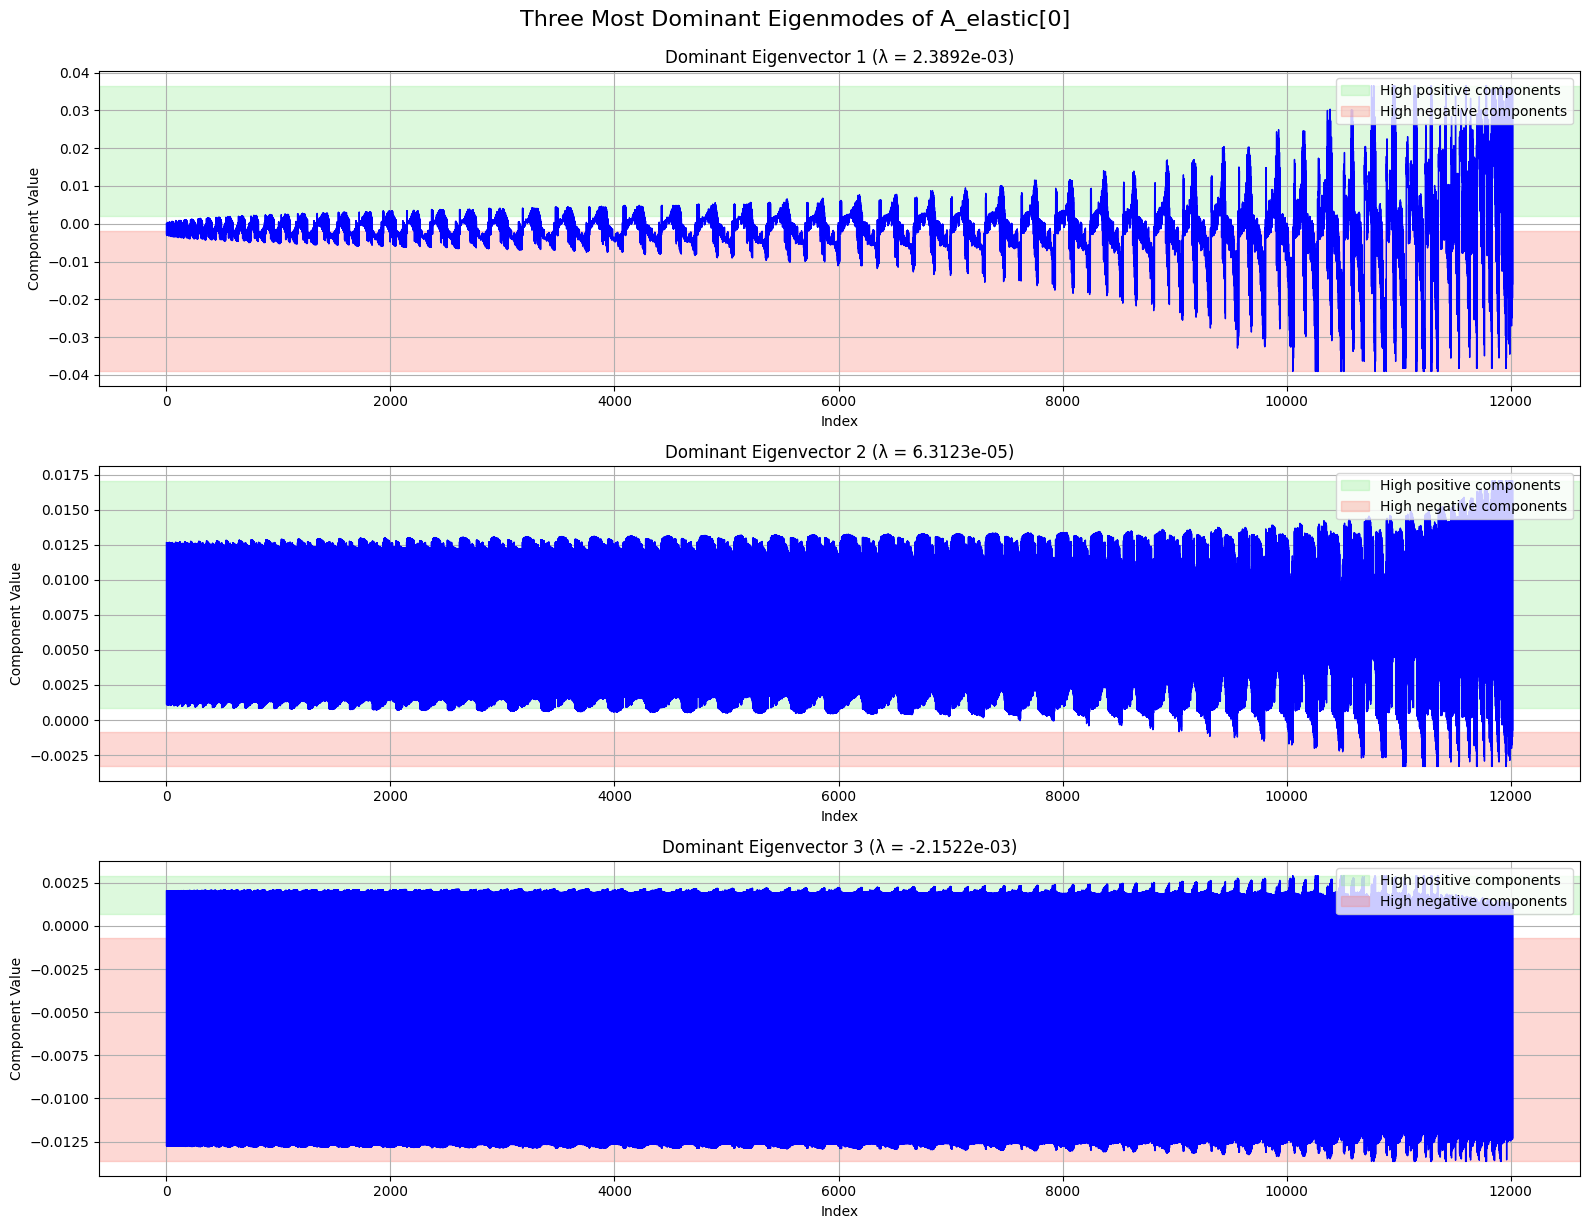

Eigenvector 1 statistics:
  - Eigenvalue: 2.3892e-03
  - L2 norm: 1.0000
  - Min/Max: -3.9108e-02 / 3.6574e-02
  - Significant components (>5% of max): 8525

Eigenvector 2 statistics:
  - Eigenvalue: 6.3123e-05
  - L2 norm: 1.0000
  - Min/Max: -3.3114e-03 / 1.7073e-02
  - Significant components (>5% of max): 9816

Eigenvector 3 statistics:
  - Eigenvalue: -2.1522e-03
  - L2 norm: 1.0000
  - Min/Max: -1.3651e-02 / 2.9203e-03
  - Significant components (>5% of max): 12020



In [44]:
import matplotlib.pyplot as plt

# Get the last 3 eigenvectors (most dominant modes)
last_3_eigenvectors = eigenvectors[:, :3]
last_3_eigenvalues = eigenvalues[:3]

# Create a figure with 3 subplots
plt.figure(figsize=(16, 12))

# Plot each of the last 3 eigenvectors
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(last_3_eigenvectors[:, i], 'b-', linewidth=1)
    plt.title(f"Dominant Eigenvector {i+1} (λ = {last_3_eigenvalues[-i-1]:.4e})")
    plt.xlabel("Index")
    plt.ylabel("Component Value")
    plt.grid(True)
    
    # Highlight areas of high magnitude
    threshold = 0.05 * max(abs(last_3_eigenvectors[:, i]))
    significant_indices = np.where(abs(last_3_eigenvectors[:, i]) > threshold)[0]
    if len(significant_indices) > 0:
        plt.axhspan(threshold, max(last_3_eigenvectors[:, i]), 
                    color='lightgreen', alpha=0.3, label='High positive components')
        plt.axhspan(min(last_3_eigenvectors[:, i]), -threshold, 
                    color='salmon', alpha=0.3, label='High negative components')
        plt.legend(loc='upper right')

plt.tight_layout()
plt.suptitle("Three Most Dominant Eigenmodes of A_elastic[0]", fontsize=16, y=1.02)
plt.show()

# Print some statistics about these eigenvectors
for i in range(3):
    vec = last_3_eigenvectors[:, i]
    print(f"Eigenvector {i+1} statistics:")
    print(f"  - Eigenvalue: {last_3_eigenvalues[-i-1]:.4e}")
    print(f"  - L2 norm: {np.linalg.norm(vec):.4f}")
    print(f"  - Min/Max: {np.min(vec):.4e} / {np.max(vec):.4e}")
    print(f"  - Significant components (>5% of max): {len(np.where(abs(vec) > 0.05 * max(abs(vec)))[0])}")
    print()

In [46]:
import h5py

# Save the last 3 eigenvectors (kernel vectors) to HDF5 file

# Create a new HDF5 file
with h5py.File('elastic_kernel.h5', 'w') as f:
    # Save the last_3_eigenvectors as a dataset named 'R'
    f.create_dataset('R', data=last_3_eigenvectors)
    
    # Add some attributes with metadata
    f.attrs['description'] = 'Kernel vectors of the elastic operator'
    f.attrs['num_vectors'] = last_3_eigenvectors.shape[1]
    f.attrs['vector_dimension'] = last_3_eigenvectors.shape[0]
    
    # Save the corresponding eigenvalues
    f.create_dataset('eigenvalues', data=last_3_eigenvalues)

print(f"Saved {last_3_eigenvectors.shape[1]} kernel vectors to elastic_kernel.h5")
print(f"Vector dimensions: {last_3_eigenvectors.shape[0]}")
print(f"Eigenvalues: {last_3_eigenvalues}")

Saved 3 kernel vectors to elastic_kernel.h5
Vector dimensions: 12020
Eigenvalues: [-2.15219642e-03  6.31228990e-05  2.38917972e-03]


In [32]:
import scipy.sparse as sp

def construct_A_from_blocks(blocks):
    """
    Constructs a full matrix from 2x2 block structure
    
    Parameters:
    -----------
    blocks : list of scipy.sparse matrices
        List containing [A11, A12, A21, A22] blocks
    
    Returns:
    --------
    A : scipy.sparse.csr_matrix
        The constructed full matrix with block structure
        [A11, A12]
        [A21, A22]
    """
    if len(blocks) != 4:
        raise ValueError("Expected 4 blocks in the list")
    
    A11, A12, A21, A22 = blocks
    
    # Check that dimensions are compatible
    
    # Construct the top and bottom rows
    top_row = sp.hstack([A11, A12])
    bottom_row = sp.hstack([A21, A22])
    
    # Stack them vertically
    A = sp.vstack([top_row, bottom_row])
    
    # Ensure the result is in CSR format for efficiency
    return A.tocsr()

# Verify our construction by comparing with A_big
constructed_A = construct_A_from_blocks(blocks)


In [35]:
diff_norm = sp.linalg.norm((constructed_A - A_big[0]))
print(f"Relative difference between constructed A and A_big: {diff_norm:.2e}")

# Check dimensions
print(f"A_big shape: {A_big[0].shape}")
print(f"Constructed A shape: {constructed_A.shape}")

# Compare number of non-zeros
print(f"A_big non-zeros: {A_big[0].nnz}")
print(f"Constructed A non-zeros: {constructed_A.nnz}")

Relative difference between constructed A and A_big: 3.66e+13
A_big shape: (13539, 13539)
Constructed A shape: (13539, 13539)
A_big non-zeros: 398577
Constructed A non-zeros: 398577


In [38]:
import numpy as np

idx = 100
rhs_u_timestep = rhs_u[idx]
rhs_p_timestep = rhs_p[idx]
sol_u_timestep = sol_u[idx]
sol_p_timestep = sol_p[idx]

import scipy.sparse.linalg as spla

# Concatenate the right-hand side vectors
rhs_combined = np.concatenate([rhs_u_timestep, rhs_p_timestep])

# Solve the system using sparse direct solver
solution = spla.spsolve(constructed_A, rhs_combined)

# Split the solution back into displacement and pressure components
u_solution = solution[:len(rhs_u_timestep)]
p_solution = solution[len(rhs_u_timestep):]

# Calculate residual to check solution quality
residual = constructed_A @ solution - rhs_combined
residual_norm = np.linalg.norm(residual)
relative_residual = residual_norm / np.linalg.norm(rhs_combined)

print(f"Solution shape: {solution.shape}")
print(f"Residual norm: {residual_norm:.2e}")
print(f"Relative residual: {relative_residual:.2e}")

# Compare with stored solution
u_error = np.linalg.norm(u_solution - sol_u_timestep) / np.linalg.norm(sol_u_timestep)
p_error = np.linalg.norm(p_solution - sol_p_timestep) / np.linalg.norm(sol_p_timestep)
print(f"Relative error in u: {u_error:.2e}")
print(f"Relative error in p: {p_error:.2e}")

Solution shape: (13539,)
Residual norm: 2.16e+04
Relative residual: 5.01e-05
Relative error in u: 1.23e-05
Relative error in p: 2.09e-05


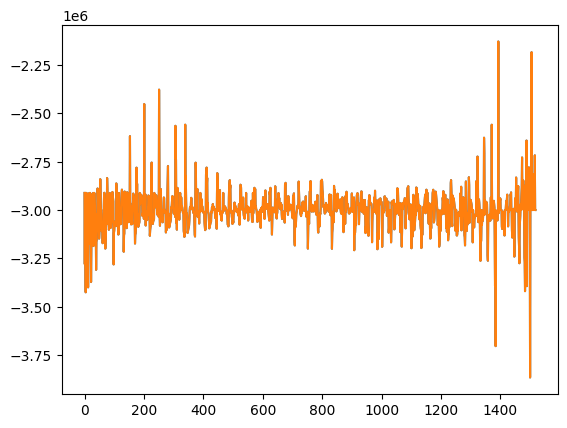

In [37]:
import matplotlib.pyplot as plt
plt.plot(sol_p_timestep)
plt.plot(p_solution)

A_big shape: (13539, 13539)
Number of non-zero elements: 398577
Density: 0.217440%
Is symmetric: False


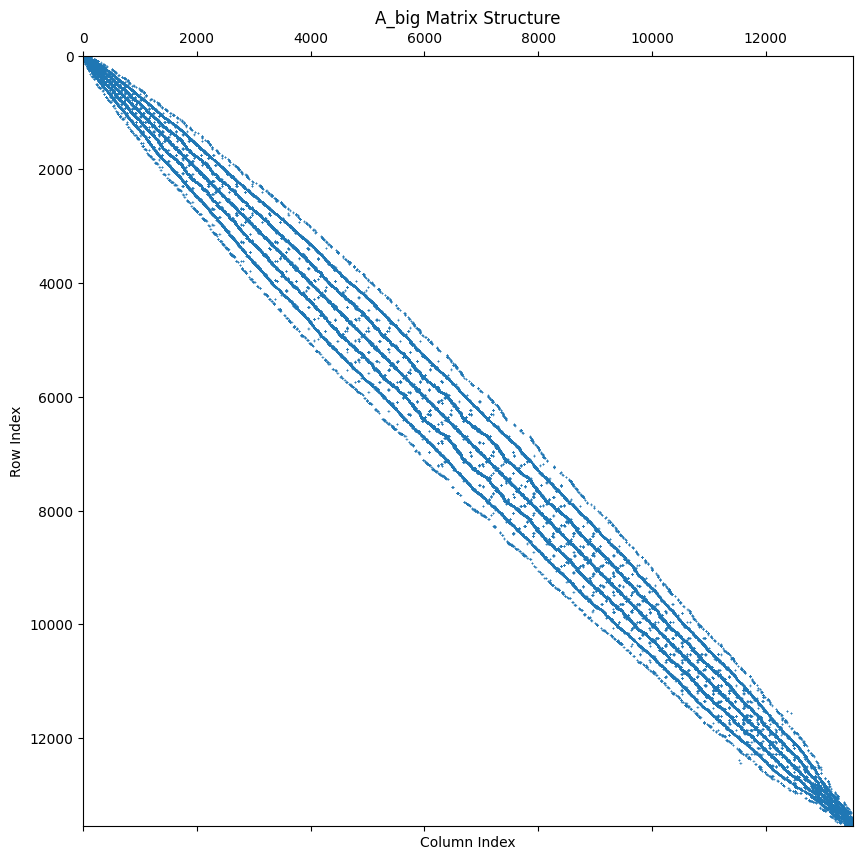

In [20]:
from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt
import scipy.sparse as sp

# Create a spy plot of A_big matrix to visualize its structure
plt.figure(figsize=(10, 10))
plt.spy(A_big, markersize=0.1)
plt.title('A_big Matrix Structure')
plt.xlabel('Column Index')
plt.ylabel('Row Index')

# Print basic information about the matrix
print(f"A_big shape: {A_big.shape}")
print(f"Number of non-zero elements: {A_big.nnz}")
print(f"Density: {A_big.nnz / (A_big.shape[0] * A_big.shape[1]) * 100:.6f}%")

# Check if the matrix is symmetric
is_symmetric = (A_big != A_big.T).nnz == 0
print(f"Is symmetric: {is_symmetric}")

# Calculate condition number estimate if matrix is not too large
if A_big.shape[0] < 10000:
    try:
        u, s, vt = svds(A_big, k=2)
        cond_est = s[0] / s[-1]
        print(f"Estimated condition number: {cond_est:.2e}")
    except:
        print("Condition number estimation failed or matrix is too large")